In [ ]:
from google.colab import drive
drive.mount('./Mbako')

Drive already mounted at ./Mbako; to attempt to forcibly remount, call drive.mount("./Mbako", force_remount=True).


In [ ]:
#IMPORT PACKAGE
from PIL import Image
import pathlib
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow.keras.utils import img_to_array, load_img

In [ ]:
#MAKE TRAIN AND VALIDATION DIRECTORY

#DON'T FORGET TO CHANGE THE DIRECTORY PATH
train_dir = "./Mbako/MyDrive/Mbako/Dataset Tembakau/Training/"
train_rendah_dir = os.path.join(train_dir, "Rendah/")
train_sedang_dir = os.path.join(train_dir, "Sedang/")
train_tinggi_dir = os.path.join(train_dir, "Tinggi/")
train_unknown_dir = os.path.join(train_dir, "Unknown/")

#DON'T FORGET TO CHANGE THE DIRECTORY PATH
validation_dir = "./Mbako/MyDrive/Mbako/Dataset Tembakau/Validation/"
validation_rendah_dir = os.path.join(validation_dir, "Rendah/")
validation_sedang_dir = os.path.join(validation_dir, "Sedang/")
validation_tinggi_dir = os.path.join(validation_dir, "Tinggi/")
validation_unknown_dir = os.path.join(validation_dir, "Unknown/")

In [ ]:
# Load the first example of a Garangan Tobacco low class
sample_image  = load_img(f"{os.path.join(train_rendah_dir, os.listdir(train_rendah_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")



Each image has shape: (300, 300, 3)
The maximum pixel value used is: 218.0


In [ ]:
def image_generator(train_dir,validation_dir):
    # Instantiate the ImageDataGenerator class.
    # Remember to set the rescale argument.
    train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode="nearest")

    # Specify the method to load images from a directory and pass in the appropriate arguments:
    # - directory: should be a relative path to the directory containing the data
    # - targe_size: set this equal to the resolution of each image (excluding the color dimension)
    # - batch_size: number of images the generator yields when asked for a next batch. Set this to 10.
    # - class_mode: How the labels are represented. Should be one of "binary", "categorical" or "sparse".
    #               Pick the one that better suits here given that the labels are going to be 1D binary labels.
    train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                        target_size=(224, 224),
                                                        batch_size=16,
                                                        class_mode="categorical")

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    # Remember that validation data should not be augmented
    validation_datagen = ImageDataGenerator( rescale = 1/255 )

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                 batch_size=16,
                                                                 class_mode='categorical',
                                                                 target_size=(224, 224))
    ### END CODE HERE

    return train_generator,validation_generator

In [ ]:
train_generator, validation_generator = image_generator(train_dir, validation_dir)

Found 284 images belonging to 4 classes.
Found 86 images belonging to 4 classes.


In [ ]:
# # Import the inception model
# from tensorflow.keras.applications.inception_v3 import InceptionV3

# # Create an instance of the inception model from the local pre-trained weights
# #DON'T FORGET TO CHANGE THE DIRECTORY PATH
# local_weights_file = './Mbako/MyDrive/Mbako/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
from tensorflow.keras.applications.mobilenet import MobileNet

# Load the VGG16 model
pre_trained_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


In [ ]:
# create_pre_trained_model

# def create_pre_trained_model(local_weights_file):
#   """
#   Initializes an InceptionV3 model.

#   Args:
#     local_weights_file (string): path pointing to a pretrained weights H5 file

#   Returns:
#     pre_trained_model: the initialized InceptionV3 model
#   """
#   ### START CODE HERE
#   pre_trained_model = MobileNet(input_shape = (300, 300, 3),
#                                   include_top = False,
#                                   weights = None)

#   pre_trained_model.load_weights(local_weights_file)

#   # Make all the layers in the pre-trained model non-trainable
#   for layer in pre_trained_model.layers:
#     layer.trainable = False

#   ### END CODE HERE

#   return pre_trained_model

In [ ]:
# pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
# Define a Callback class that stops training once accuracy reaches 95%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.96 and logs.get('accuracy')>0.96):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
# output_of_last_layer

def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model

  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

  Returns:
    last_output: output of the model's last layer
  """
  ### START CODE HERE
  last_desired_layer = pre_trained_model.get_layer('conv_dw_13_relu')#conv_dw_10_relu
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  ### END CODE HERE

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 1024)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1024), dtype=tf.float32, name=None), name='conv_dw_13_relu/Relu6:0', description="created by layer 'conv_dw_13_relu'")


In [ ]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [ ]:
def create_uncompiled_model():

    ### START CODE HERE

    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)

    ### START CODE HERE

    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = layers.Dense(256, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)
    # Add a final sigmoid layer for classification
    x = x = layers.Dense  (3, activation='softmax')(x)

    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)

    ### END CODE HERE

    return model

In [ ]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_generator)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

18/18 [==============================] - 22s 951ms/step
Your current architecture is compatible with the windowed dataset! :)


In [ ]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

    ### START CODE HERE

    # Select your optimizer
    optimizer = tf.keras.optimizers.Adam()

    # Compile the model passing in the appropriate loss
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=["accuracy"])

    ### END CODE HERE

    history = model.fit(train_generator, epochs=200, callbacks=[lr_schedule])

    return history

In [ ]:
'''# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_generator)'''

'# Run the training with dynamic LR\nlr_history = adjust_learning_rate(train_generator)'

In [ ]:
'''plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])'''

'plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])\nplt.axis([1e-4, 10, 0, 10])'

In [ ]:
#create_final_model

def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model

  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

  Returns:
    model: the combined model
  """
  # SAMAKAN MODEL FINAL DENGAN MODEL UNCOMPILED
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  ### START CODE HERE

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(256, activation='relu')(x)
  # Add a dropout rate
  x = layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = x = layers.Dense(4, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

  ### END CODE HERE

  return model

In [ ]:
# model.summary()

In [ ]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 15,022,532 total parameters in this model.
There are 15,002,692 trainable parameters in this model.


In [ ]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 300,
                    callbacks=callbacks,
                    verbose = 1)

Epoch 1/300
18/18 [==============================] - 29s 618ms/step - loss: 24.9092 - accuracy: 0.5634 - precision: 0.5603 - recall: 0.5563 - val_loss: 13.8530 - val_accuracy: 0.6279 - val_precision: 0.6279 - val_recall: 0.6279
Epoch 2/300
18/18 [==============================] - 10s 547ms/step - loss: 8.2372 - accuracy: 0.6585 - precision: 0.6585 - recall: 0.6585 - val_loss: 3.7134 - val_accuracy: 0.7791 - val_precision: 0.7791 - val_recall: 0.7791
Epoch 3/300
18/18 [==============================] - 9s 535ms/step - loss: 3.9798 - accuracy: 0.7148 - precision: 0.7138 - recall: 0.7113 - val_loss: 14.9075 - val_accuracy: 0.6512 - val_precision: 0.6512 - val_recall: 0.6512
Epoch 4/300
18/18 [==============================] - 9s 483ms/step - loss: 1.6610 - accuracy: 0.7430 - precision: 0.7500 - recall: 0.7289 - val_loss: 1.1488 - val_accuracy: 0.7674 - val_precision: 0.7765 - val_recall: 0.7674
Epoch 5/300
18/18 [==============================] - 12s 655ms/step - loss: 0.6565 - accuracy: 

In [ ]:
predictions = model.predict(train_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels=train_generator.classes

confusion_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)

# Extract the true positives, true negatives, and false positives
true_positives = np.diag(confusion_matrix)
true_negatives = np.sum(confusion_matrix) - np.sum(confusion_matrix, axis=0) - np.sum(confusion_matrix, axis=1) + true_positives
false_positives = np.sum(confusion_matrix, axis=0) - true_positives
false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

# Print the results for each class
for i in range(3):
    print("Class", i)
    print("True Positives:", true_positives[i])
    print("True Negatives:", true_negatives[i])
    print("False Positives:", false_positives[i])
    print("False Negatives:", false_negatives[i])

18/18 [==============================] - 8s 416ms/step
Class 0
True Positives: 9
True Negatives: 199
False Positives: 37
False Negatives: 39
Class 1
True Positives: 8
True Negatives: 203
False Positives: 35
False Negatives: 38
Class 2
True Positives: 8
True Negatives: 205
False Positives: 38
False Negatives: 33


In [ ]:
train_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype=int32)

In [ ]:
model.predict(train_generator)

18/18 [==============================] - 9s 475ms/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [3.0069820e-15, 9.1933411e-22, 1.0000000e+00, 5.1427841e-18],
       [1.9688559e-06, 9.9999797e-01, 9.8395680e-10, 1.2466722e-19],
       ...,
       [9.9999869e-01, 1.2962075e-06, 1.0620504e-09, 6.0474091e-11],
       [5.4445337e-12, 2.9541442e-17, 1.0000000e+00, 3.4375297e-14],
       [9.7035373e-17, 8.0979907e-18, 6.1823033e-20, 1.0000000e+00]],
      dtype=float32)

In [ ]:
confusion_matrix

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 9,  3, 10, 26],
       [ 7,  8,  8, 23],
       [ 7,  5,  8, 21],
       [23, 27, 20, 79]], dtype=int32)>

In [ ]:
np.sum(np.diag(confusion_matrix))/np.sum(confusion_matrix)

0.36619718309859156

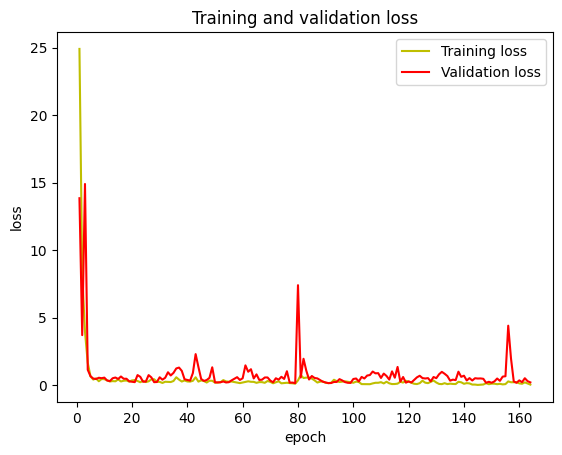

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'y',label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

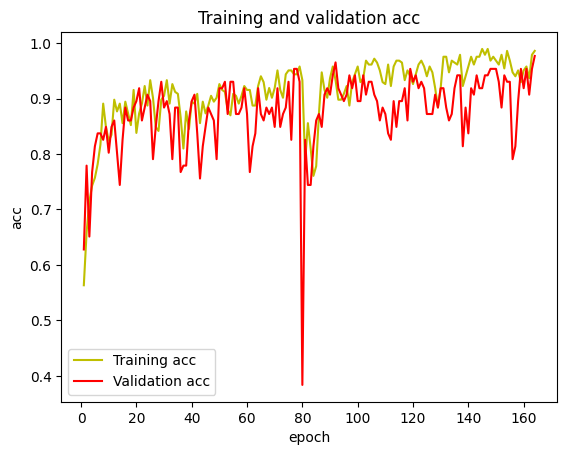

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,len(loss)+1)

plt.plot(epochs,acc,'y',label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict_generator(validation_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels=validation_generator.classes

confusion_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)

# Extract the true positives, true negatives, and false positives
true_positives = np.diag(confusion_matrix)
true_negatives = np.sum(confusion_matrix) - np.sum(confusion_matrix, axis=0) - np.sum(confusion_matrix, axis=1) + true_positives
false_positives = np.sum(confusion_matrix, axis=0) - true_positives
false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

# Print the results for each class
for i in range(3):
    print("Class", i)
    print("True Positives:", true_positives[i])
    print("True Negatives:", true_negatives[i])
    print("False Positives:", false_positives[i])
    print("False Negatives:", false_negatives[i])

<ipython-input-28-af8a9803e842>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(validation_generator)


Class 0
True Positives: 1
True Negatives: 57
False Positives: 14
False Negatives: 14
Class 1
True Positives: 1
True Negatives: 70
False Positives: 8
False Negatives: 7
Class 2
True Positives: 1
True Negatives: 62
False Positives: 11
False Negatives: 12


In [ ]:
confusion_matrix

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 1,  3,  2,  9],
       [ 0,  1,  3,  4],
       [ 4,  1,  1,  7],
       [10,  4,  6, 30]], dtype=int32)>

In [ ]:
# Count false positives for each class
false_positives = np.zeros(3)  # Initialize an array to store false positives for each class

for i in range(3):
    false_positives[i] = np.sum((predicted_labels == i) & (true_labels != i))

# Print false positives for each class
for i in range(3):
    print("False positives for class", i, ":", false_positives[i])

False positives for class 0 : 14.0
False positives for class 1 : 8.0
False positives for class 2 : 11.0


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=16)
  print(fn)
  print(classes)

Saving 20210223_181106.jpg to 20210223_181106.jpg
1/1 [==============================] - 1s 654ms/step
20210223_181106.jpg
[[7.5276499e-04 9.4473781e-03 2.6114762e-04 9.8953867e-01]]


In [ ]:
model.save('./Mbako/MyDrive/Mbako/SaveModelV4/modelV4.pb')
model.save('./Mbako/MyDrive/Mbako/SaveModelV4/modelV4.h5')

In [ ]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format.
export_dir = './Mbako/MyDrive/Mbako/SaveModelV4'

# YOUR CODE HERE
tf.saved_model.save(model,export_dir=export_dir)


In [ ]:
model.save('./Mbako/MyDrive/Mbako/SaveModelV4/model')

In [ ]:
my_model = tf.keras.models.load_model('./Mbako/MyDrive/Mbako/SaveModelV4/model')

In [ ]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter
# YOUR CODE HERE
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('./Mbako/MyDrive/Mbako/SaveModelV4/modelV4.tflite')
tflite_model_file.write_bytes(tflite_model)

15162584

In [ ]:
# open('./Mbako/MyDrive/Project Bangkit/SaveModelV4/Model.tflite','wb').write(tflite_model)


15162584